Loading libraries

In [ ]:
pip install causalgraphicalmodels

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

import networkx as nx

Functions for independence testing

In [ ]:
def is_indep(arr_1, arr_2, threshold=0.01, verbose=False):
    diff = arr_1.mean() * arr_2.mean() - (arr_1 * arr_2).mean()
    if verbose:
        print(diff)
    return abs(diff) < threshold

def is_cond_independent(data_df, var_1, var_2, cond_set):
    # create a copy with different combinations of values in cond_set
    data_df_tmp = data_df.copy()
    tmp_arr = data_df_tmp[cond_set[0]].astype(str).values
    for el in cond_set[1:]:
        tmp_arr += ' ' + data_df_tmp[el].astype(str)
    data_df_tmp['cond'] = tmp_arr

    # get unique combinations of values in cond_set
    cond_vals = data_df_tmp['cond'].unique()

    # for every possible combination check if we have independence
    for cond_val in cond_vals:
        tmp_df = data_df_tmp[data_df_tmp['cond'] == cond_vals[0]]
        if not is_indep(tmp_df[var_1].values, tmp_df[var_2].values):
            return False
    return True

# Generating data

For data generation we will be using python package [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels)

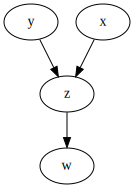

In [ ]:
fd0 = StructuralCausalModel({
    "x": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "y": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "z": discrete_model(["x", "y"], {
        (0,0): (0.1,0.9,), 
        (0,1): (0.3,0.7,),
        (1,0): (0.8,0.2,),
        (1,1): (0.9,0.1,),
        }),
    "w": discrete_model(["z"],{
        (0,): (0.8,0.2,),
        (1,): (0.1,0.9,), 
    })
})

fd0.cgm.draw()

Now we can sample data from the generated model

In [ ]:
n_samples=1000000
# n_samples=1000
data_df = fd0.sample(n_samples=n_samples)

# Step 1. Fully connected graph

In [ ]:
all_nodes = ['x', 'y', 'z', 'w']
nodes_pos = {'x': (1, 5), 'y': (5, 5), 'z': (1, 1), 'w': (5, 1)}

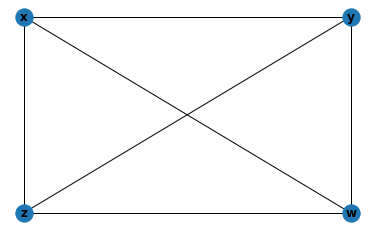

In [ ]:
G = nx.Graph()
G.add_nodes_from(all_nodes)
#G.add_nodes_from(tuple(zip(all_nodes, nodes_pos)))

for i in range(0, len(all_nodes)):
    node_1 = all_nodes[i]
    for j in range(i+1, len(all_nodes)):
        node_2 = all_nodes[j]
        G.add_edge(node_1, node_2)

plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

# Step 2. Test unconditional independence

In [ ]:
for i in range(0, len(all_nodes)):
    var_1 = all_nodes[i]
    for j in range(i + 1, len(all_nodes)):
        var_2 = all_nodes[j]
        # testStat, thresh = hsic_gam(data_df[var_1].values.reshape(-1, 1), data_df[var_2].values.reshape(-1, 1), alph=alph)
        # print(testStat, thresh)
        print("{} and {} are independent: {}".format(var_1, var_2, 
                                                     is_indep(data_df[var_1].values, data_df[var_2].values)))

x and y are independent: True
x and z are independent: False
x and w are independent: False
y and z are independent: False
y and w are independent: False
z and w are independent: False


Removing edge between $X$ and $Y$

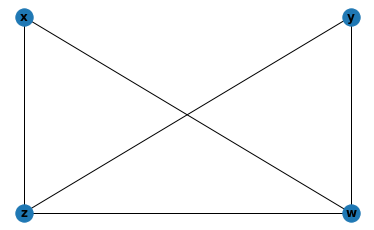

In [ ]:
G.remove_edge('x', 'y')
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

# Step 3. Condition on 1 variable
For each pair of variables ($A$, $B$) having an edge between them, and for each variable $C$ with an edge connected to either of them, eliminate the edge between $A$ and $B$ if $\left(A ⊥⊥ B\right) | C$ 

In [ ]:
combinations = [
                ('x', 'z', 'w'), ('x', 'z', 'y'), 
                ('y', 'w', 'z'), ('y', 'w', 'x'),
                ('z', 'w', 'x'), ('z', 'w', 'y'),
                ('x', 'w', 'z'), ('x', 'w', 'y'),
                ('y', 'z', 'x'), ('y', 'z', 'w'),
                ]

In [ ]:
for var_1, var_2, cond_var in combinations:
    print('{} and {} are independent given {} = {}'.format(
        var_1, var_2, cond_var, is_cond_independent(data_df, var_1, var_2, [cond_var])
    ))

x and z are independent given w = False
x and z are independent given y = False
y and w are independent given z = True
y and w are independent given x = False
z and w are independent given x = False
z and w are independent given y = False
x and w are independent given z = True
x and w are independent given y = False
y and z are independent given x = False
y and z are independent given w = False


Removing edges between $Y$ and $W$ and between $X$ and $W$

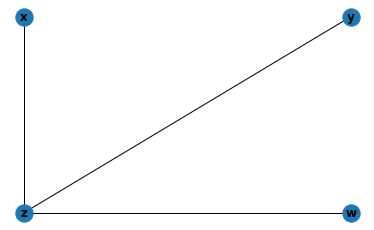

In [ ]:
G.remove_edge('y', 'w')
G.remove_edge('x', 'w')
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

# Step 4. ...

# Step 5. Search for v-structure

Consider 3 cases:
1. $W - Z - Y$
2. $W - Z - X$
3. $X - Z - Y$

3-d case can be oriented as $X -> Z <- Y$

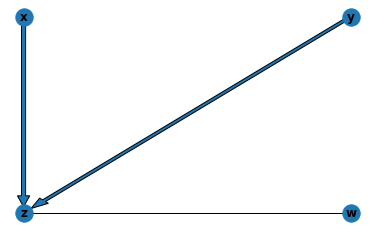

In [ ]:
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

plt.arrow(1, 5, 0, -3.65, width=0.05)       # X - > Z
plt.arrow(5, 5, -3.75, -3.75, width=0.05)   # Y - > Z

# Step 6. Orientation propagation

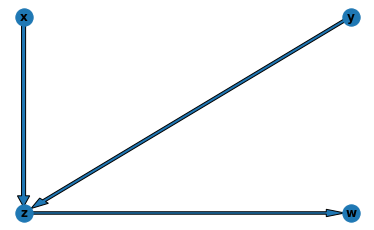

In [ ]:
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

plt.arrow(1, 5, 0, -3.65, width=0.05)       # X - > Z
plt.arrow(5, 5, -3.75, -3.75, width=0.05)   # Y - > Z
plt.arrow(1, 1, 3.7, 0, width=0.05)   # Z - > W